# Identification of a nonlinear isotropic hardening rule

In this demo, we use stress/plastic strain data of a steel material to show how to identify a nonlinear isotropic hardening rule with `jaxmat`.

```{admonition} Objectives
:class: important

In particular, this demo shows:

- How to define a trainable hardening rule based on an extended phenomenological expression
- How to define a trainable hardening rule based on an Input-Convex Neural Network
- How to train both models on a subset of noisy data
- How to evaluate the models outside the training range
```

## Loading and preprocessing experimental data

We start by importing the necessary packages and loading experimental uniaxial stress–strain data from a steel sample. Data has been obtained from the X100 data used in [the MEALOR "Simulation of ductile fracture models" lab session](https://github.com/MEALORII/TP_MEALOR/blob/main/TP5_Ductile_fracture/TP5_GTN_model.ipynb), see also {cite:p}`besson2023mealor`. The data represent the evolution of the yield stress as a function of equivalent plastic strain $p$.

To test the robustness of our identification procedure, we artificially add a small amount of Gaussian noise to both the stress and plastic strain values. The noisy data are then sorted and truncated to define a training subset limited to $p<5.10^{-2}$, leaving the rest for extrapolation.

The plot below shows the ground-truth stress–strain curve and the noisy data used for training.

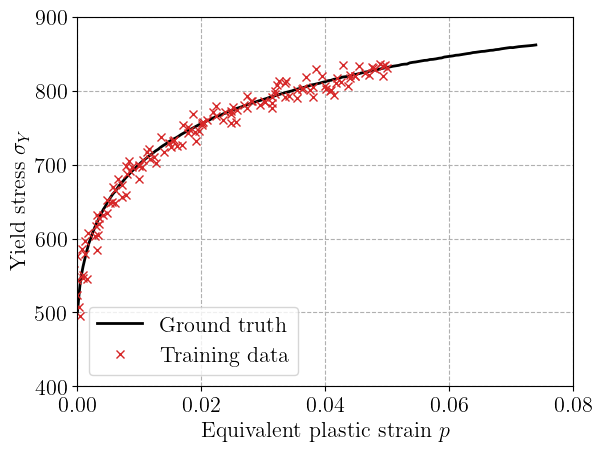

In [ ]:
import jax

jax.config.update("jax_platform_name", "cpu")
import jax.numpy as jnp

from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import equinox as eqx
import optimistix as optx
from jaxmat.nn.icnn import ICNN, ICNNSkip

current_path = Path().resolve()

data = np.loadtxt(current_path / "X100.csv", skiprows=1, delimiter=",")
epsp = data[:, 0]
sig = data[:, 1]

key = jax.random.key(42)
key1, key2 = jax.random.split(key)

noise_level = 0.01
sig_noise = sig + noise_level * max(sig) * jax.random.normal(key1, shape=(len(sig),))
epsp_noise = epsp + noise_level * max(epsp) * jax.random.normal(key2, shape=(len(sig),))

# sort and extract training region
indices = jnp.argsort(epsp_noise)[epsp_noise < 5e-2]
epsp_noise = epsp_noise[indices]
sig_noise = sig_noise[indices]

plt.figure()
plt.plot(epsp, sig, "-k", label="Ground truth")
plt.plot(epsp_noise, sig_noise, "xC3", linewidth=1, label="Training data")
plt.xlim(0, 8e-2)
plt.xlabel("Equivalent plastic strain $p$")
plt.ylabel("Yield stress $\sigma_Y$")
plt.legend()

## Defining candidate hardening laws

We now define two different models for the isotropic hardening law $\sigma_Y(p)$:

- Phenomenological Sum-Exponential Model:
    We consider an extended version of the Voce hardening law, where the yield stress saturates exponentially with plastic strain. We consider here a sum of $N$ saturating exponentials written as:

    $$\sigma_Y(p) = \sigma_0 + \sum_{i=1}^N \Delta\sigma_i \big(1 - \exp(-b_i p))$$

    where the parameters $\sigma_0$, $\Delta\sigma_i$, and $b_i$ are learnable. Here $\sigma_0$ denotes the initial yield stress and $\sigma_0+\sum_i \Delta\sigma_i$ will correspond to the saturating stress.

- Neural Network Model based on Input-Convex Neural Networks (ICNN):
    This model enforces convexity of the potential by construction, guaranteeing a monotonic hardening behavior. The yield stress is defined as the gradient of the convex potential output by the ICNN, see also [](../neural_network_models/hyperelastic_PANN).

Both models are implemented as `equinox.Module`s, allowing them to be handled as JAX PyTrees and trained with differentiable solvers.

In [ ]:
class SumExpHardening(eqx.Module):
    sig0: float = eqx.field(converter=jnp.asarray)
    dsigu: jax.Array = eqx.field(converter=jnp.asarray)
    b: jax.Array = eqx.field(converter=jnp.asarray)

    def __call__(self, p):
        return self.sig0 + jnp.sum(self.dsigu * (1 - jnp.exp(-self.b * p)))


N = 20
sumexp_hardening = SumExpHardening(
    sig0=1000.0,
    dsigu=jax.random.lognormal(key1, shape=(N,)),
    b=jax.random.lognormal(key2, shape=(N,)),
)


class HardeningICNN(ICNN):
    def __call__(self, p):
        return jax.grad(super().__call__)(p)


icnn_hardening = HardeningICNN(0, [N], key)

## Defining the loss function

The training process minimizes a loss function that measures the mean squared error between the predicted yield stress $\hat{\sigma}_Y(p)$ and the noisy data. To prevent overfitting and promote smoothness, we add an $L^1$ regularization term on the model parameters:

$$
\mathcal{L}(\btheta) = \dfrac{1}{M}\sum_{k=1}^M (\hat\sigma_Y(p^{(k)};\btheta) - \sigma_Y^\text{data,(k)})^2 + \dfrac{\gamma}{n_{\btheta}} \|\btheta\|_1
$$

where $M$ is the number of data points, $\gamma$ is a regularization coefficient and $n_{\btheta}$ denotes the total number of parameters in $\btheta$. Both the data loss and the regularization term are written in a fully JAX-compatible manner.

In [ ]:
def loss(hardening, args):
    epsp, sig = args
    M = len(epsp)
    sig_hat = jax.vmap(hardening)(epsp)
    return jnp.sum((sig_hat - sig) ** 2) / M, sig_hat


def l1reg(hardening):
    flat_params, _ = jax.flatten_util.ravel_pytree(eqx.filter(hardening, eqx.is_array))
    return jnp.linalg.vector_norm(flat_params, ord=1) / len(flat_params)


@eqx.filter_jit
def total_loss(hardening, args):
    data, gamma = args
    data_loss, sig_hat = loss(hardening, data)
    return data_loss + gamma * l1reg(hardening), sig_hat

## Training procedure

We use the quasi-Newton BFGS solver from the `optimistix` library to minimize the total loss. The BFGS algorithm is particularly well suited for small parameter sets and ensures fast convergence without the need for stochastic optimization.

Each hardening model (phenomenological and ICNN-based) is trained independently on the same noisy dataset.

During optimization, the solver adjusts the parameters to best reproduce the measured yield stress values. Thanks to JAX’s automatic differentiation, all gradients are computed exactly and efficiently.

Note that $\gamma$ is a hyperparameter which must be tuned by chosen before hand by the user.

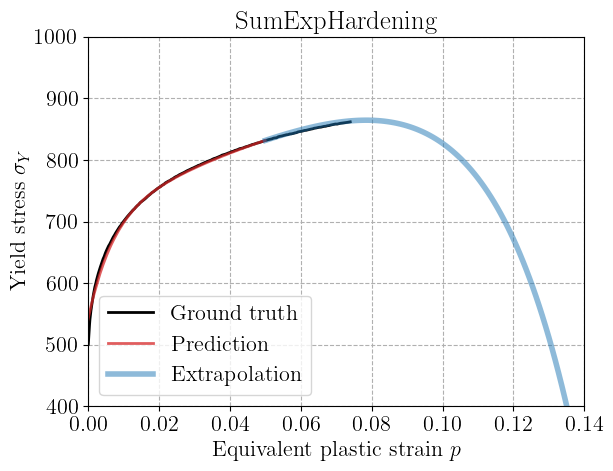

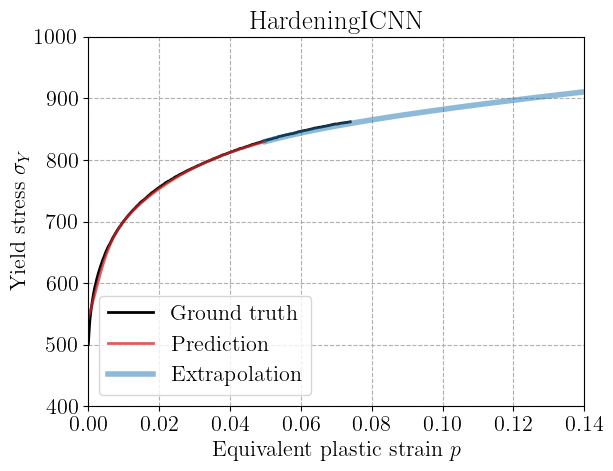

In [ ]:
gamma = 0.1
solver = optx.BFGS(
    rtol=1e-6,
    atol=1e-8,
    #  verbose=frozenset({"loss", "step_size"})
)

training_data = (epsp_noise, sig_noise)
for hardening in [sumexp_hardening, icnn_hardening]:
    sol = optx.minimise(
        total_loss,
        solver,
        hardening,
        args=(training_data, gamma),
        has_aux=True,
        throw=False,
        max_steps=1000,
    )
    trained_hardening = sol.value
    sig_hat = sol.aux

    plt.figure()
    plt.plot(epsp, sig, "-k", label="Ground truth")
    plt.plot(epsp_noise, sig_hat, "-C3", alpha=0.75, label="Prediction")

    epsp_extrap = jnp.linspace(5e-2, 14e-2, 100)
    sig_extrap = jax.vmap(trained_hardening)(epsp_extrap)
    plt.plot(
        epsp_extrap, sig_extrap, "-C0", linewidth=4, alpha=0.5, label="Extrapolation"
    )
    plt.xlim(0, 14e-2)
    plt.ylim(400, 1e3)
    plt.xlabel("Equivalent plastic strain $p$")
    plt.ylabel("Yield stress $\sigma_Y$")
    plt.title(hardening.__class__.__name__)
    plt.legend()

## Results and extrapolation

After training, we visualize the predicted hardening curves along with the experimental data. The solid black line shows the ground truth, red crosses the noisy training data,

We also evaluate the models beyond the training range ($p > 5.10^{-2}$) in blue to test their extrapolation capability.
This is important for constitutive modeling since we often need to predict material behavior beyond the calibrated strain range.

Typically, the phenomenological `SumExp` model performs well within the training range but may struggle when generalizing outside the training region. We can check that tuning the hyperparameter $\gamma$ or increasing the number of terms does not yield much better results. In this case, it is preferable to use a relatively small number $N$ of terms in the expansion.

Conversely, the ICNN-based model can learn more flexible shapes while still guaranteeing monotonic hardening, thanks to its convexity constraint. As a result, it performs relatively well outside the training range in general.

## References

```{bibliography}
:filter: docname in docnames
```